## load data, shift to AEST and land only, clip to fire scar

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from scipy.stats import mannwhitneyu
import pandas as pd
import matplotlib.lines as mlines

In [2]:
datapath = f'/g/data/ng72/as9583/cylc-run/u-dr216/netcdf_new'
variable = 'boundary_layer_thickness'

experiment1 = 'drysoil_d0198_RAL3P2_albedo_bare_' 
allvar = xr.open_dataset(f'{datapath}/{variable}/{experiment1}{variable}.nc')['atmosphere_boundary_layer_thickness']

experiment2 = 'control_d0198_RAL3P2_' 
control = xr.open_dataset(f'{datapath}/{variable}/{experiment2}{variable}.nc')['atmosphere_boundary_layer_thickness']

experiment3 = 'control_d0198_RAL3P2_albedo_bare_'
albedo_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment3}{variable}.nc')['atmosphere_boundary_layer_thickness']

experiment4 = 'control_d0198_RAL3P2_albedo_'
albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment4}{variable}.nc')['atmosphere_boundary_layer_thickness']

experiment5 = 'control_d0198_RAL3P2_bare_'
bare = xr.open_dataset(f'{datapath}/{variable}/{experiment5}{variable}.nc')['atmosphere_boundary_layer_thickness']

experiment6 = 'drysoil_d0198_RAL3P2_albedo_'
SM_albedo = xr.open_dataset(f'{datapath}/{variable}/{experiment6}{variable}.nc')['atmosphere_boundary_layer_thickness']

experiment7 = 'drysoil_d0198_RAL3P2_bare_'
SM_bare = xr.open_dataset(f'{datapath}/{variable}/{experiment7}{variable}.nc')['atmosphere_boundary_layer_thickness']

experiment8 = 'drysoil_d0198_RAL3P2_'
SM = xr.open_dataset(f'{datapath}/{variable}/{experiment8}{variable}.nc')['atmosphere_boundary_layer_thickness']

In [3]:
#clip to land only
variable3 = 'land_sea_mask'
landmask = xr.open_dataset(f'{datapath}/{variable3}/{experiment1}{variable3}.nc')["land_binary_mask"].isel(time=0)
allvar = allvar.where(landmask == 1)
control = control.where(landmask == 1)
albedo_bare = albedo_bare.where(landmask == 1)
albedo = albedo.where(landmask == 1)
bare = bare.where(landmask == 1)
SM_albedo = SM_albedo.where(landmask == 1)
SM_bare = SM_bare.where(landmask == 1)
SM = SM.where(landmask == 1)

In [4]:
experiments = {
    "All Variables": allvar,
    "Control": control,
    "Albedo + Bare": albedo_bare,
    "Albedo": albedo,
    "Bare": bare,
    "SM + Albedo": SM_albedo,
    "SM + Bare": SM_bare,
    "SM": SM
}

#push to AEST
experiments_aest = {}
for name, da in experiments.items():
    da_aest = da.assign_coords(time=da.time + np.timedelta64(10, 'h'))
    experiments_aest[name] = da_aest

In [5]:
fires = gpd.read_file('/g/data/ng72/as9583/merged_fires.gpkg')
#clip data to within the fire scars
fires = fires.to_crs("EPSG:7844")

clipped = {}

for name, da in experiments_aest.items():
    da = da.rio.write_crs("EPSG:7844")
    
    clipped_da = da.rio.clip(fires.geometry, fires.crs, drop=True, invert=False)
    
    clipped[name] = clipped_da

In [6]:
#new data
allvar = clipped['All Variables']
control =clipped['Control']
albedo_bare =clipped['Albedo + Bare']
albedo =clipped['Albedo']
bare =clipped['Bare']
SM_albedo =clipped['SM + Albedo']
SM_bare=clipped['SM + Bare']
SM =clipped['SM']

#new dictionary for clipped
experiments_aest = {
    "All Variables": allvar,
    "Control": control,
    "Albedo + Bare": albedo_bare,
    "Albedo": albedo,
    "Bare": bare,
    "SM + Albedo": SM_albedo,
    "SM + Bare": SM_bare,
    "SM": SM
}

## diurnal cycle

In [7]:
#diurnal cycle, fire scars
diurnal_means = {}
for name, da in experiments_aest.items():
    #mean over space, group by hour
    diurnal = da.mean(dim=["latitude", "longitude"], skipna=True).groupby("time.hour").mean(skipna=True)
    diurnal_means[name] = diurnal

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Enteri

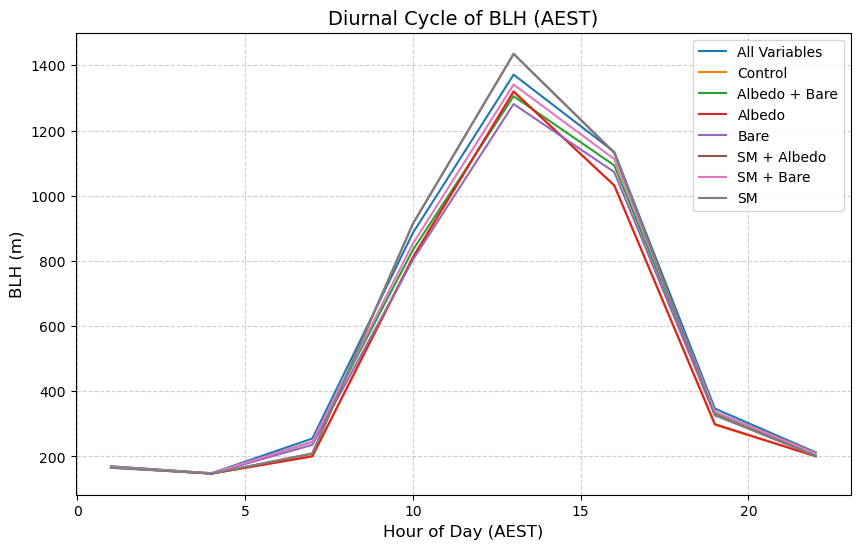

In [8]:
#total diurnal cycle
plt.figure(figsize=(10, 6))
for name, diurnal in diurnal_means.items():
    plt.plot(diurnal['hour'], diurnal.values, label=name)

plt.xlabel("Hour of Day (AEST)", fontsize=12)
plt.ylabel("BLH (m)", fontsize=12)
plt.title("Diurnal Cycle of BLH (AEST)", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## PM

In [9]:
pm4_series = {}
for name, da in experiments_aest.items():
    #spatial average
    da_spatial = da.mean(dim=["latitude", "longitude"], skipna=True)

    #get target
    target_times = da_spatial['time'].dt.floor("D") + np.timedelta64(16, "h")
    pm4 = da_spatial.sel(time=target_times, method="nearest")
    pm4_series[name] = pm4

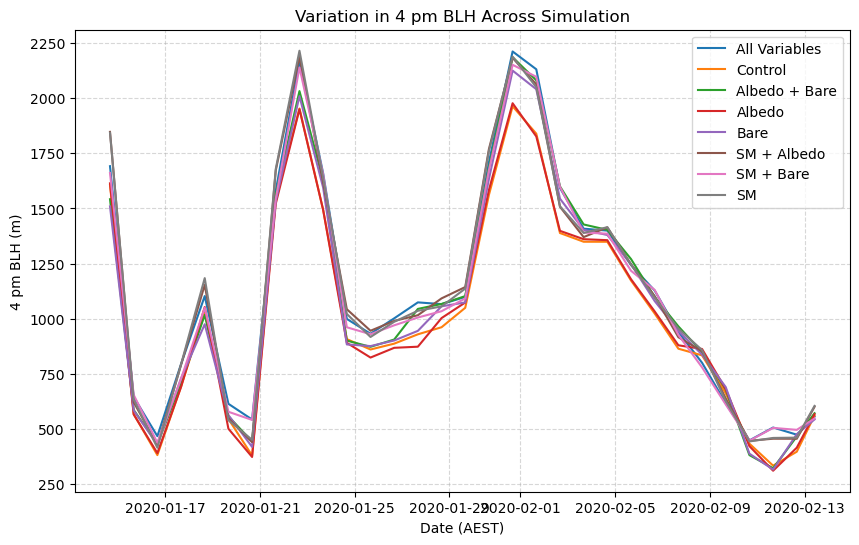

In [10]:
plt.figure(figsize=(10,6))

for name, pm4 in pm4_series.items():
    plt.plot(pm4['time'], pm4.values, label=name)

plt.xlabel("Date (AEST)")
plt.ylabel("4 pm BLH (m)")
plt.title("Variation in 4 pm BLH Across Simulation")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

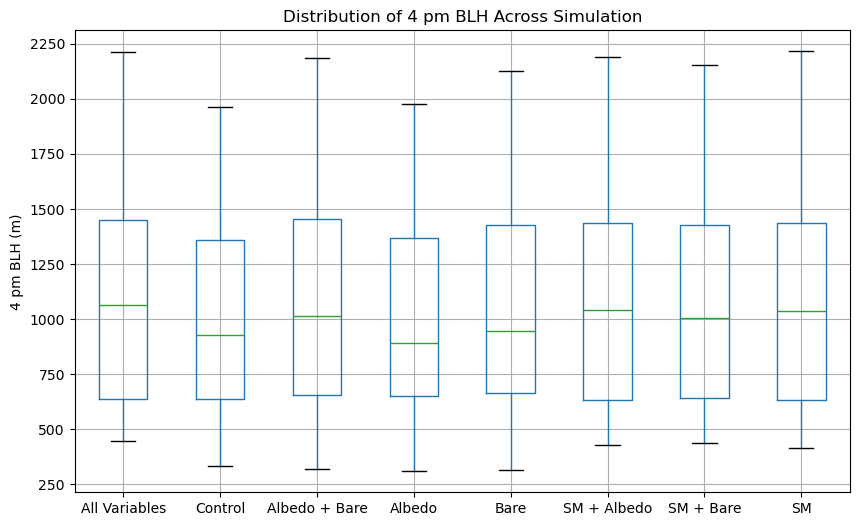

In [11]:
data = {name: pm4.values for name, pm4 in pm4_series.items()}
df = pd.DataFrame(data)

df.boxplot(figsize=(10,6))
plt.ylabel("4 pm BLH (m)")
plt.title("Distribution of 4 pm BLH Across Simulation")
plt.show()

In [12]:
ref_name = "Control"
ref = pm4_series[ref_name]

pm4_diff = {}
for name, da in pm4_series.items():
    if name != ref_name:
        #align time dimension
        da, ref_aligned = xr.align(da, ref)
        pm4_diff[name] = da - ref_aligned

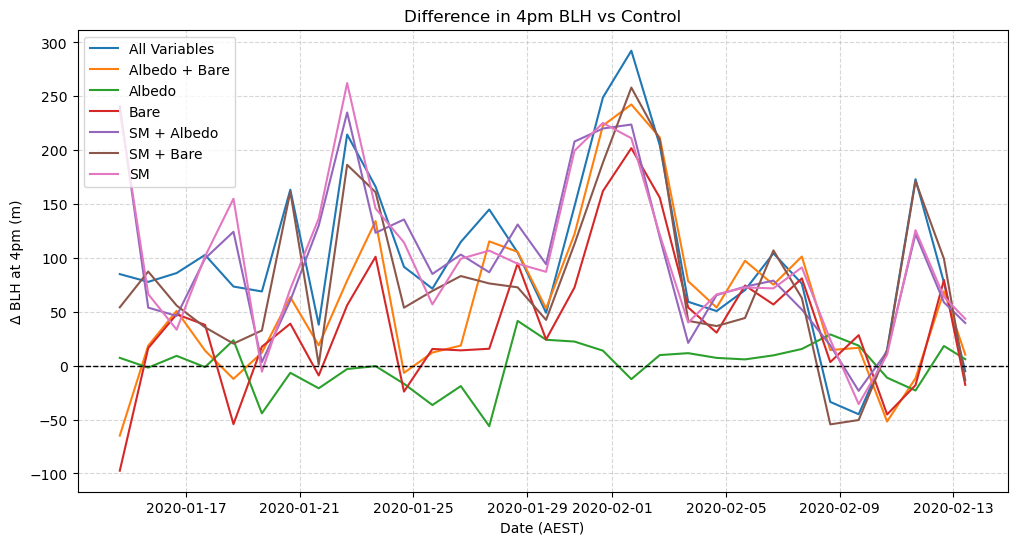

In [13]:
plt.figure(figsize=(12,6))

for name, diff in pm4_diff.items():
    plt.plot(diff['time'], diff.values, label=f"{name}")

plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Date (AEST)")
plt.ylabel("Δ BLH at 4pm (m)")
plt.title("Difference in 4pm BLH vs Control")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [14]:
#compute average diffs
avg_diffs = {}
for name, diff in pm4_diff.items():
    avg_diffs[name] = float(diff.mean().values)

print("Average 4pm temperature differences vs Control:")
for name, val in avg_diffs.items():
    print(f"{name}: {val:.2f} m")

Average 4pm temperature differences vs Control:
All Variables: 101.62 m
Albedo + Bare: 63.05 m
Albedo: 0.42 m
Bare: 42.40 m
SM + Albedo: 96.78 m
SM + Bare: 80.02 m
SM: 98.44 m


## AM 

In [15]:
am4_series = {}
for name, da in experiments_aest.items():
    #spatial average
    da_spatial = da.mean(dim=["latitude", "longitude"], skipna=True)
    
    #target time
    target_times = da_spatial['time'].dt.floor("D") + np.timedelta64(4, "h")
    am4 = da_spatial.sel(time=target_times, method="nearest")
    am4_series[name] = am4

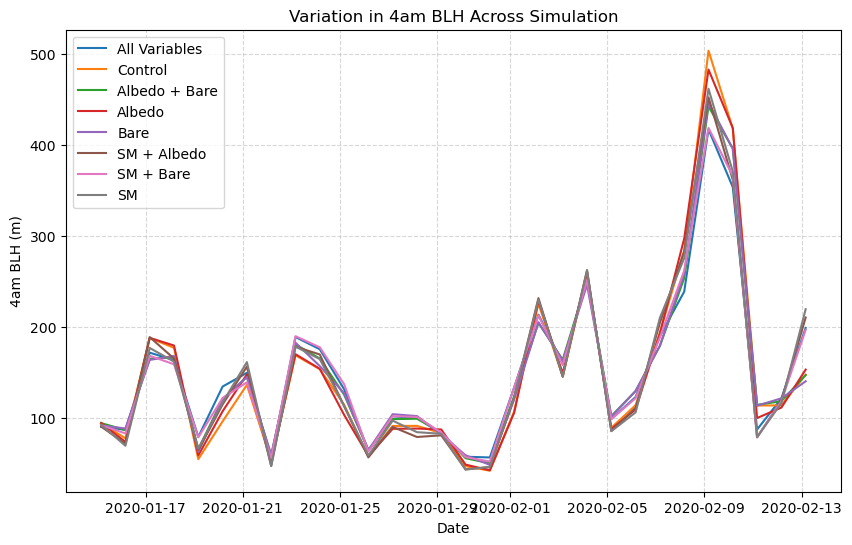

In [16]:
plt.figure(figsize=(10,6))

for name, am4 in am4_series.items():
    plt.plot(am4['time'][4:], am4.values[4:], label=name)

plt.xlabel("Date")
plt.ylabel("4am BLH (m)")
plt.title("Variation in 4am BLH Across Simulation")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

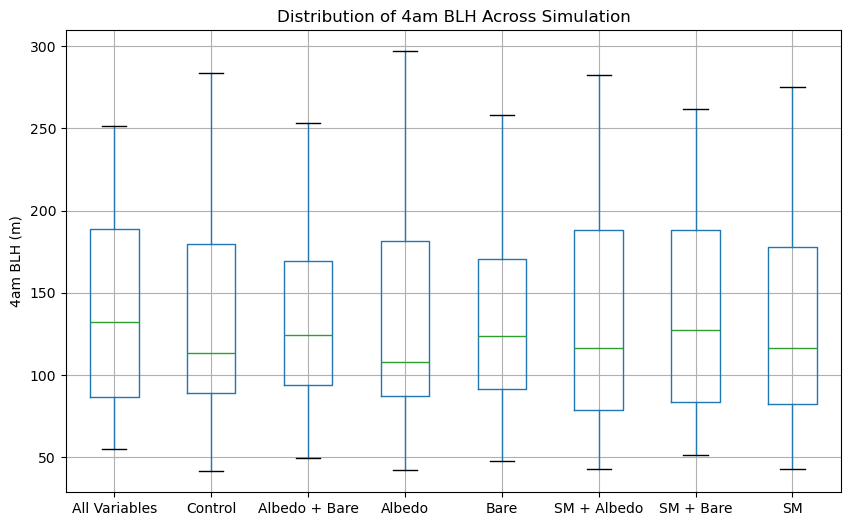

In [17]:
data = {name: am4.values for name, am4 in am4_series.items()}
df = pd.DataFrame(data)

df.boxplot(figsize=(10,6), showfliers=False) # looks diff when fliers on
plt.ylabel("4am BLH (m)")
plt.title("Distribution of 4am BLH Across Simulation")
plt.show()

In [18]:
ref_name = "Control"
ref = am4_series[ref_name]

am4_diff = {}
for name, da in am4_series.items():
    if name != ref_name:
        da, ref_aligned = xr.align(da, ref)
        am4_diff[name] = da - ref_aligned

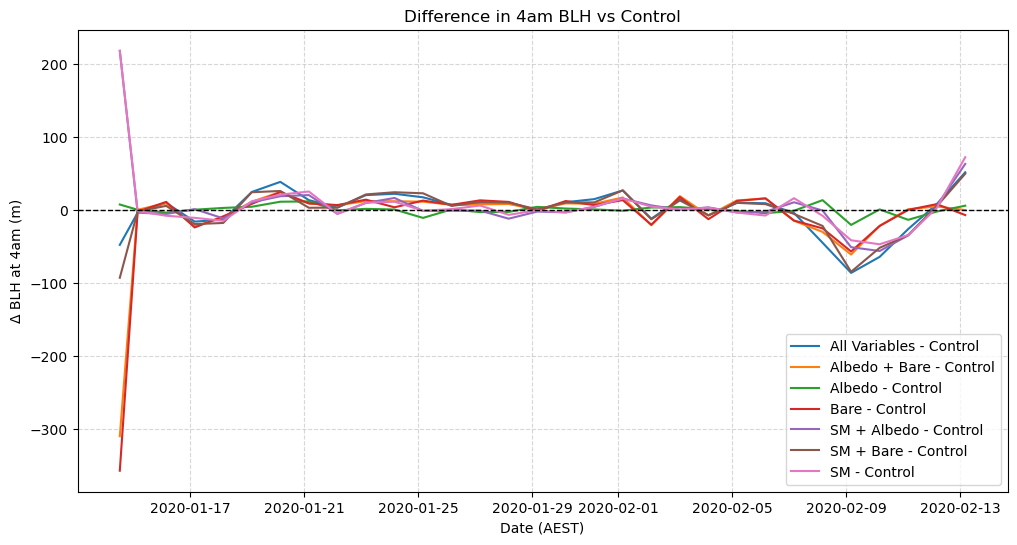

In [19]:
plt.figure(figsize=(12,6))

for name, diff in am4_diff.items():
    plt.plot(diff['time'], diff.values, label=f"{name} - {ref_name}")

plt.axhline(0, color="k", linestyle="--", linewidth=1)
plt.xlabel("Date (AEST)")
plt.ylabel("Δ BLH at 4am (m)")
plt.title("Difference in 4am BLH vs Control")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [20]:
avg_diffs = {}
for name, diff in am4_diff.items():
    avg_diffs[name] = float(diff.mean().values)

print("Average 4am temperature differences vs Control:")
for name, val in avg_diffs.items():
    print(f"{name}: {val:.2f} m")

Average 4am temperature differences vs Control:
All Variables: -0.53 m
Albedo + Bare: -4.80 m
Albedo: -0.07 m
Bare: -5.64 m
SM + Albedo: 2.02 m
SM + Bare: -1.52 m
SM: 2.58 m


In [21]:
## much more impact at 3pm than 3am